In [21]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


@Tuan

Generate the dataset in `data_processing.ipynb` and then provide the file paths here.

In [22]:
# Imports
import torch
import numpy as np

In [23]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    mps=False

else:
    mps_device = torch.device("mps")
    mps=True

    print("MPS is available and enabled on device: {}".format(mps_device))

MPS is available and enabled on device: mps


#### Model and Data Initialization

In [36]:
from model import *
from torch.utils.data import DataLoader, WeightedRandomSampler

windowed_data = np.load("data/mlp_data.np.npy")
labels = np.load("data/mlp_lbls.np.npy")

# Initialize the Dataset
data = GPS_MLP_Dataset(windowed_data, labels, device=mps_device)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

labels = data.y.cpu().numpy()
train_labels = np.asarray([labels[idx] for idx in train_dataset.indices])
class_counts = [np.count_nonzero(train_labels == 0), np.count_nonzero(train_labels == 1)]
class_weights = [1 / i for i in class_counts]
class_weights[1] = class_weights[1] 
sample_weights = [class_weights[i] for i in train_labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

# Initialize the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=16)

X Shape:  torch.Size([47085, 24])
y Shape:  torch.Size([47085])


In [39]:
# Build a dataset for just positive samples.
positive_indices = np.where(labels  == 1)[0]
pos_x = windowed_data[positive_indices]
pos_y = labels[positive_indices]
print(pos_x.shape, pos_y.shape)
pos_data = GPS_MLP_Dataset(pos_x,  pos_y, device=mps_device)
pos_dataloader = DataLoader(pos_data, batch_size=16)

(1499, 24) (1499,)
X Shape:  torch.Size([1499, 24])
y Shape:  torch.Size([1499])


In [40]:
negative_indices = np.where(labels  == 0)[0]
neg_x = windowed_data[negative_indices]
neg_y = labels[negative_indices]
print(neg_x.shape, neg_y.shape)
neg_data = GPS_MLP_Dataset(neg_x,  neg_y, device=mps_device)
neg_dataloader = DataLoader(neg_data, batch_size=16)

(45586, 24) (45586,)
X Shape:  torch.Size([45586, 24])
y Shape:  torch.Size([45586])


In [26]:
# initialize the model
# model = GPS_CNN(num_bins=21, num_channels=24)
model = GPS_MLP()
if mps:
    model = model.to(mps_device)
model

GPS_MLP(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)

### Training Loop

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [28]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 700 == 5:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss:.3f}')

    #print("got to eval")
    model.eval()
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    print(f'[{epoch + 1}] loss: {running_loss:.3f}, accuracy: {correct / len(test_dataset):.3f}') 
    model.train()

[1,     6] loss: 17.853
[1,   706] loss: 1.554
[1,  1406] loss: 0.440
[1,  2106] loss: 0.362
[1] loss: 370.440, accuracy: 0.671
[2,     6] loss: 0.647
[2,   706] loss: 0.591
[2,  1406] loss: 0.341
[2,  2106] loss: 0.701
[2] loss: 287.463, accuracy: 0.790
[3,     6] loss: 0.363
[3,   706] loss: 0.825
[3,  1406] loss: 0.757
[3,  2106] loss: 0.201
[3] loss: 296.131, accuracy: 0.788
[4,     6] loss: 0.524
[4,   706] loss: 0.468
[4,  1406] loss: 0.704
[4,  2106] loss: 0.316
[4] loss: 290.178, accuracy: 0.794
[5,     6] loss: 0.266
[5,   706] loss: 0.453
[5,  1406] loss: 0.313
[5,  2106] loss: 0.802
[5] loss: 256.773, accuracy: 0.812
[6,     6] loss: 0.410
[6,   706] loss: 0.535
[6,  1406] loss: 0.451
[6,  2106] loss: 0.367
[6] loss: 254.706, accuracy: 0.810
[7,     6] loss: 0.500
[7,   706] loss: 0.972
[7,  1406] loss: 0.548
[7,  2106] loss: 0.305
[7] loss: 231.651, accuracy: 0.820
[8,     6] loss: 0.651
[8,   706] loss: 0.343
[8,  1406] loss: 0.807
[8,  2106] loss: 0.546
[8] loss: 248.446,

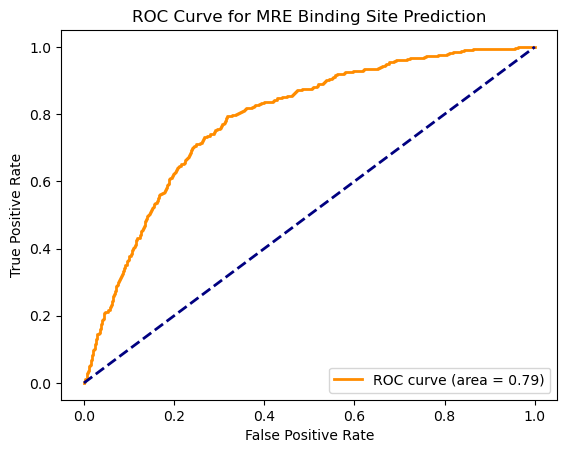

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from torch.autograd import Variable

model.eval()
y_true = []
y_score = []
gradients = []
# with torch.no_grad():
for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    inputs.requires_grad = True

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_score.extend(outputs.data.cpu().numpy())

    loss = criterion(outputs, labels)
    loss.backward()

    gradient = gradients.extend(list((inputs.grad).cpu().numpy()))

y_true = np.array(y_true)
y_score = np.array(y_score)
gradients = np.asarray(gradients)

fpr, tpr, _ = roc_curve((y_true == 1), (y_score[:,1]))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for MRE Binding Site Prediction')
plt.show()


Text(0.5, 1.0, 'Confusion Matrix for MRE Binding Site Prediction')

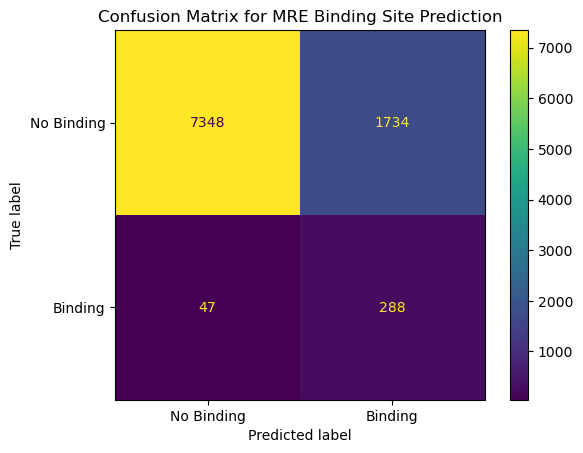

In [41]:
## Make the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_score, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Binding', 'Binding'], )
disp.plot()
disp.ax_.set_title('Confusion Matrix for MRE Binding Site Prediction')


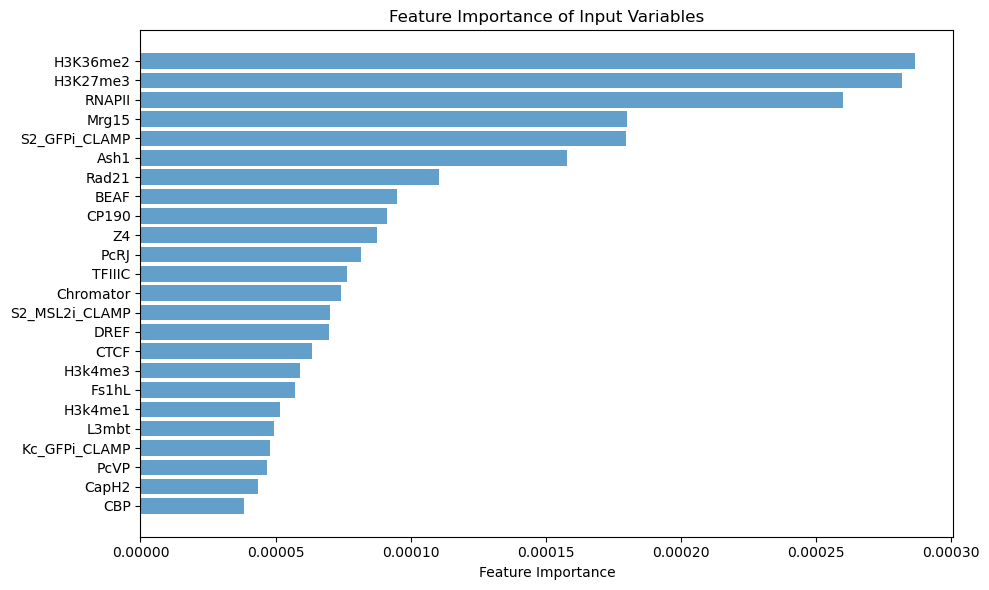

In [42]:
import matplotlib.pyplot as plt

# Assuming you have feature_importance values and a list of names corresponding to the 24 input variables
# feature_importance and variable_names are assumed to be lists or arrays of equal lengths

# Replace these with your actual values
feature_importance =  np.mean(np.abs(np.array(gradients)), axis=0)
variable_names = ['S2_GFPi_CLAMP', 'S2_MSL2i_CLAMP', 'CapH2', 'CP190', 'CTCF', 'Chromator', 'BEAF', 'CBP', 'H3k4me1', 'DREF', 'H3k4me3', 'Fs1hL', 'L3mbt', 'Kc_GFPi_CLAMP', 'PcRJ', 'Z4', 'PcVP', 'TFIIIC', 'RNAPII', 'Rad21', 'Ash1', 'H3K27me3', 'H3K36me2', 'Mrg15']

# Sorting by feature importance for better visualization
sorted_indices = sorted(range(len(feature_importance)), key=lambda k: feature_importance[k])
sorted_feature_importance = [feature_importance[i] for i in sorted_indices]
sorted_variable_names = [variable_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center', alpha=0.7)
plt.yticks(range(len(sorted_variable_names)), sorted_variable_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Input Variables')
plt.tight_layout()
plt.show()

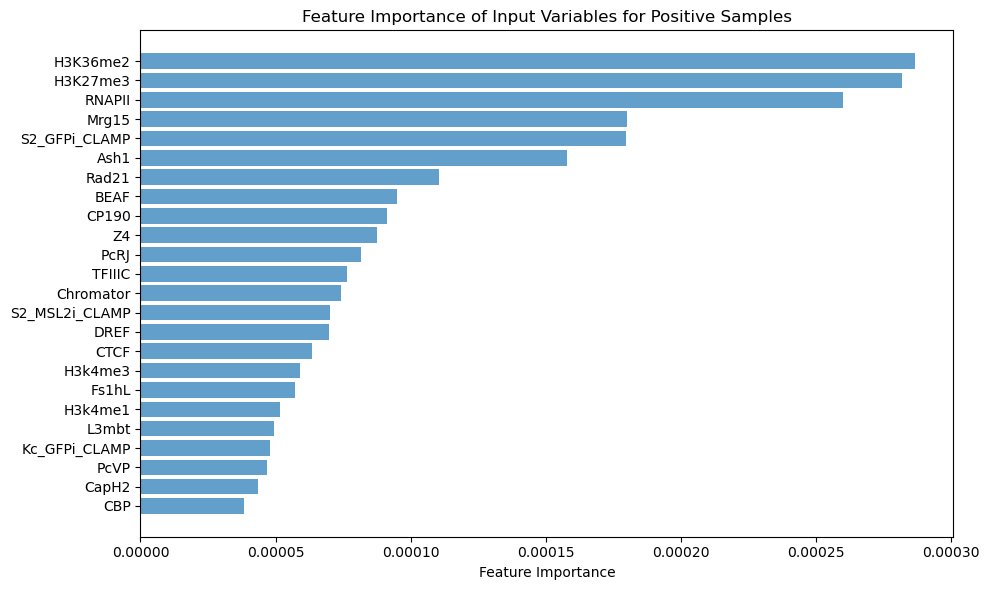

In [43]:
# Computing the Gradients on JUST the positive samples.
model.eval()
gradients = []
# with torch.no_grad():
for i, data in enumerate(pos_dataloader, 0):
    inputs, labels = data
    inputs.requires_grad = True

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    gradient = gradients.extend(list((inputs.grad).cpu().numpy()))

gradients = np.asarray(gradients)
feature_importance =  np.mean(np.abs(np.array(gradients)), axis=0)

variable_names = ['S2_GFPi_CLAMP', 'S2_MSL2i_CLAMP', 'CapH2', 'CP190', 'CTCF', 'Chromator', 'BEAF', 'CBP', 'H3k4me1', 'DREF', 'H3k4me3', 'Fs1hL', 'L3mbt', 'Kc_GFPi_CLAMP', 'PcRJ', 'Z4', 'PcVP', 'TFIIIC', 'RNAPII', 'Rad21', 'Ash1', 'H3K27me3', 'H3K36me2', 'Mrg15']

# Sorting by feature importance for better visualization
sorted_indices = sorted(range(len(feature_importance)), key=lambda k: feature_importance[k])
sorted_feature_importance = [feature_importance[i] for i in sorted_indices]
sorted_variable_names = [variable_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center', alpha=0.7)
plt.yticks(range(len(sorted_variable_names)), sorted_variable_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Input Variables for Positive Samples')
plt.tight_layout()
plt.show()

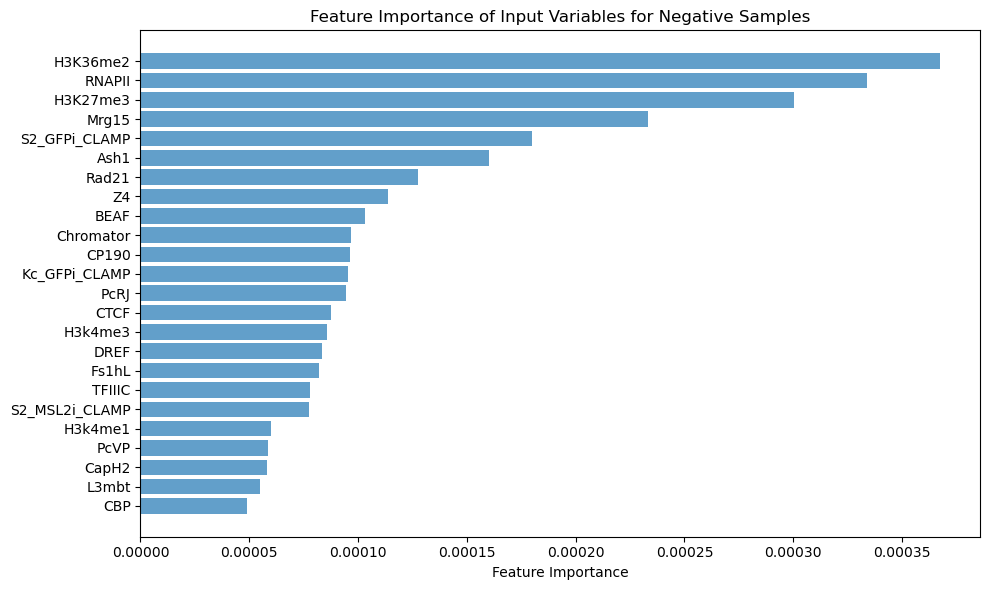

In [44]:
model.eval()
gradients = []
# with torch.no_grad():
for i, data in enumerate(neg_dataloader, 0):
    inputs, labels = data
    inputs.requires_grad = True

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    gradient = gradients.extend(list((inputs.grad).cpu().numpy()))

gradients = np.asarray(gradients)
feature_importance =  np.mean(np.abs(np.array(gradients)), axis=0)

variable_names = ['S2_GFPi_CLAMP', 'S2_MSL2i_CLAMP', 'CapH2', 'CP190', 'CTCF', 'Chromator', 'BEAF', 'CBP', 'H3k4me1', 'DREF', 'H3k4me3', 'Fs1hL', 'L3mbt', 'Kc_GFPi_CLAMP', 'PcRJ', 'Z4', 'PcVP', 'TFIIIC', 'RNAPII', 'Rad21', 'Ash1', 'H3K27me3', 'H3K36me2', 'Mrg15']

# Sorting by feature importance for better visualization
sorted_indices = sorted(range(len(feature_importance)), key=lambda k: feature_importance[k])
sorted_feature_importance = [feature_importance[i] for i in sorted_indices]
sorted_variable_names = [variable_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center', alpha=0.7)
plt.yticks(range(len(sorted_variable_names)), sorted_variable_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Input Variables for Negative Samples')
plt.tight_layout()
plt.show()